# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

In [4]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif

from gaussian_model import create_and_draw_best_gaussian_mix
from gaussian_model import create_gaussian_model

from create_prediction import create_prediction
from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals
from print_examples import print_examples


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100


#valitaan käsittelyyn tuleva alue PKS
selected = stat[(stat['muncipality_code']==91) | (stat['muncipality_code']==92) | (stat['muncipality_code']==49) | (stat['muncipality_code']==235)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==91) | (vaalidata['Kuntanumero']==92) | (vaalidata['Kuntanumero']==49) | (vaalidata['Kuntanumero']==235) ].copy()
post_included = post[(post['muncipality_code']==91) | (post['muncipality_code']==92) | (post['muncipality_code']==49) | (post['muncipality_code']==235)]['postcode'].copy()

#valitaan käsittelyyn tuleva alue FI1B1 = Uusimaa
selected = stat[stat['area_code']=='FI1B1'].copy()
selected_vaalidata = vaalidata[vaalidata['area_code']=='FI1B1'].copy()
post_included = post[post['area_code']=='FI1B1'].copy()

selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()

n_components = 2
n_clusters = 6
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0
covariance_type = 'full'

filename_model_aic = 'aic_cluster'
filename_model_bic = 'bic_cluster'

data, X, test, gmm_bic, gmm_aic = create_and_draw_best_gaussian_mix(filename_model_aic, filename_model_bic, path, selected, selected, numeric_features=numeric_features, categorical_features=categorical_features, scaled=scaled, covariance_type = covariance_type)
data = create_gaussian_model(data, X, gmm_bic)

print(data['cluster'].value_counts())



load model
Silhouette Coefficient: 0.101 Calinski Harabaz Index: 242
2    1059
3    1033
0     491
4     236
1     151
Name: cluster, dtype: int64


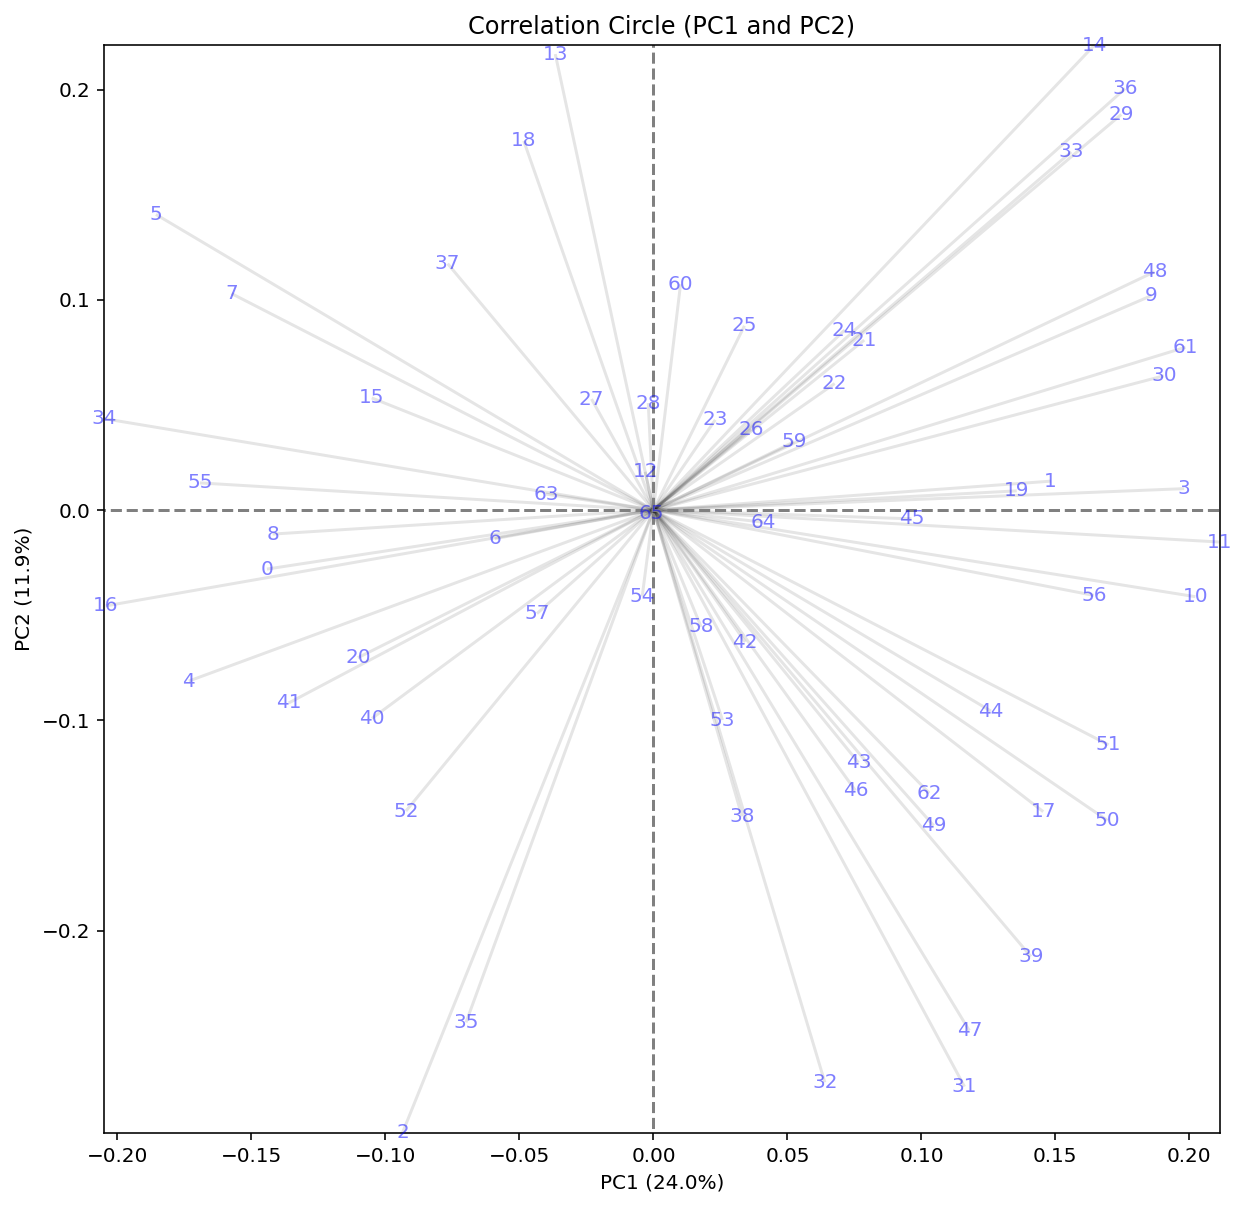

In [5]:
from draw_and_create_clusters import display_circles

axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [6]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

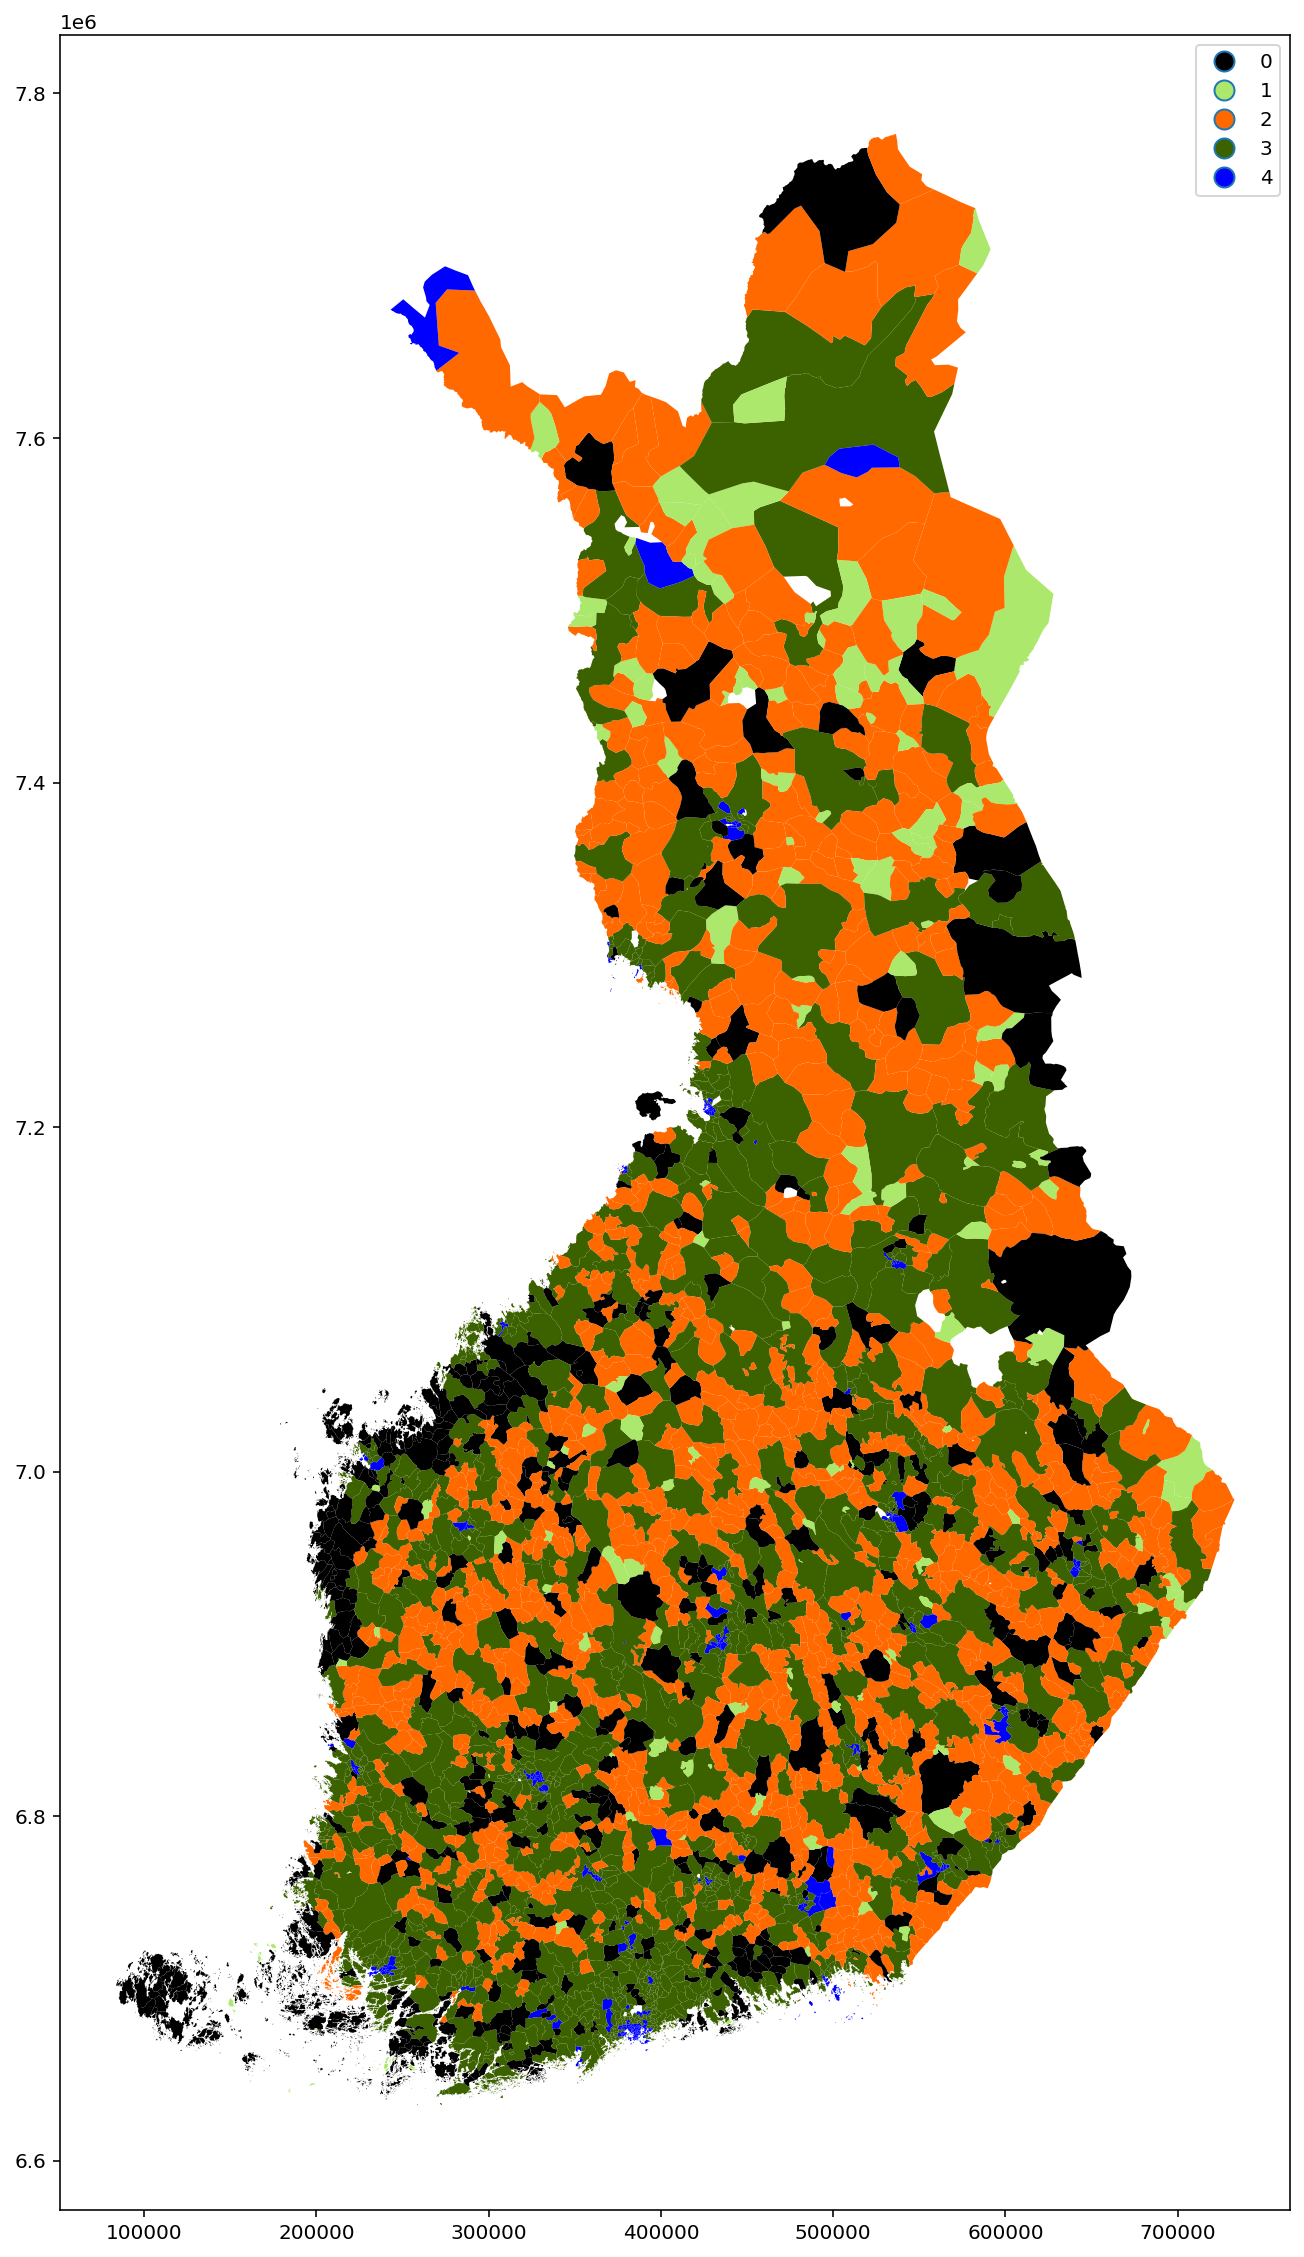

In [7]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [8]:


target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'gauss_xgboost_cluster'
data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


load model


In [9]:
filename_model = 'gauss_mymodel_xgboost_cluster'
filename_shap =  'gauss_shap.npz'
mymodel, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


load model
load shap files


invalid value encountered in true_divide
invalid value encountered in true_divide


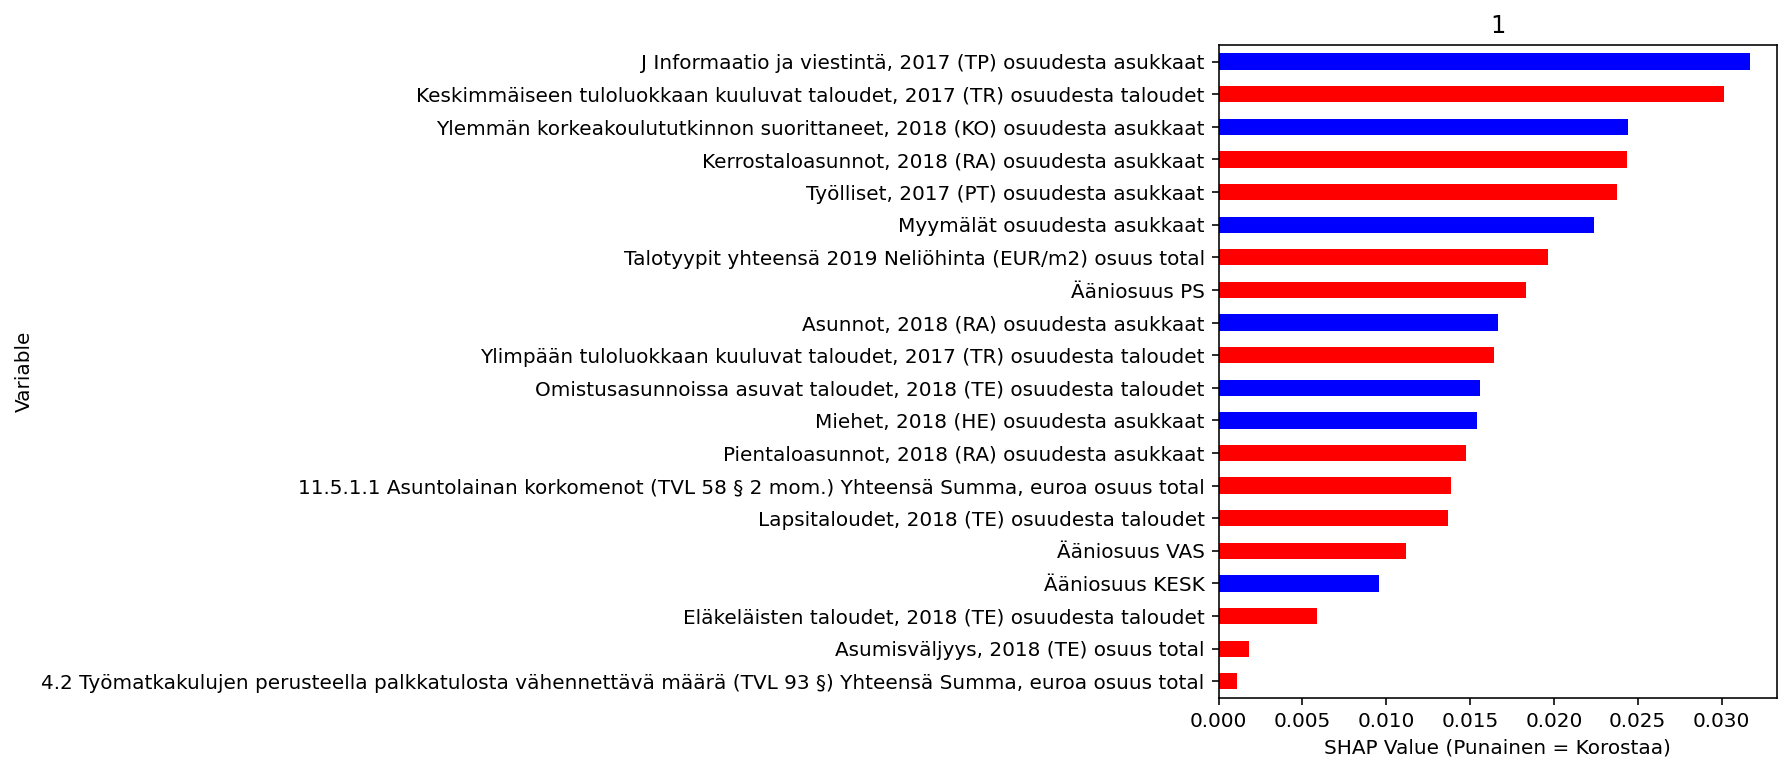

In [10]:

vals = shap_vals(X, 1, shap_values[3])

In [11]:
data[ennustettu] = mymodel.predict(X)
data["ennustettu 2"] = model.predict(xgb.DMatrix(X, label=data[target]))

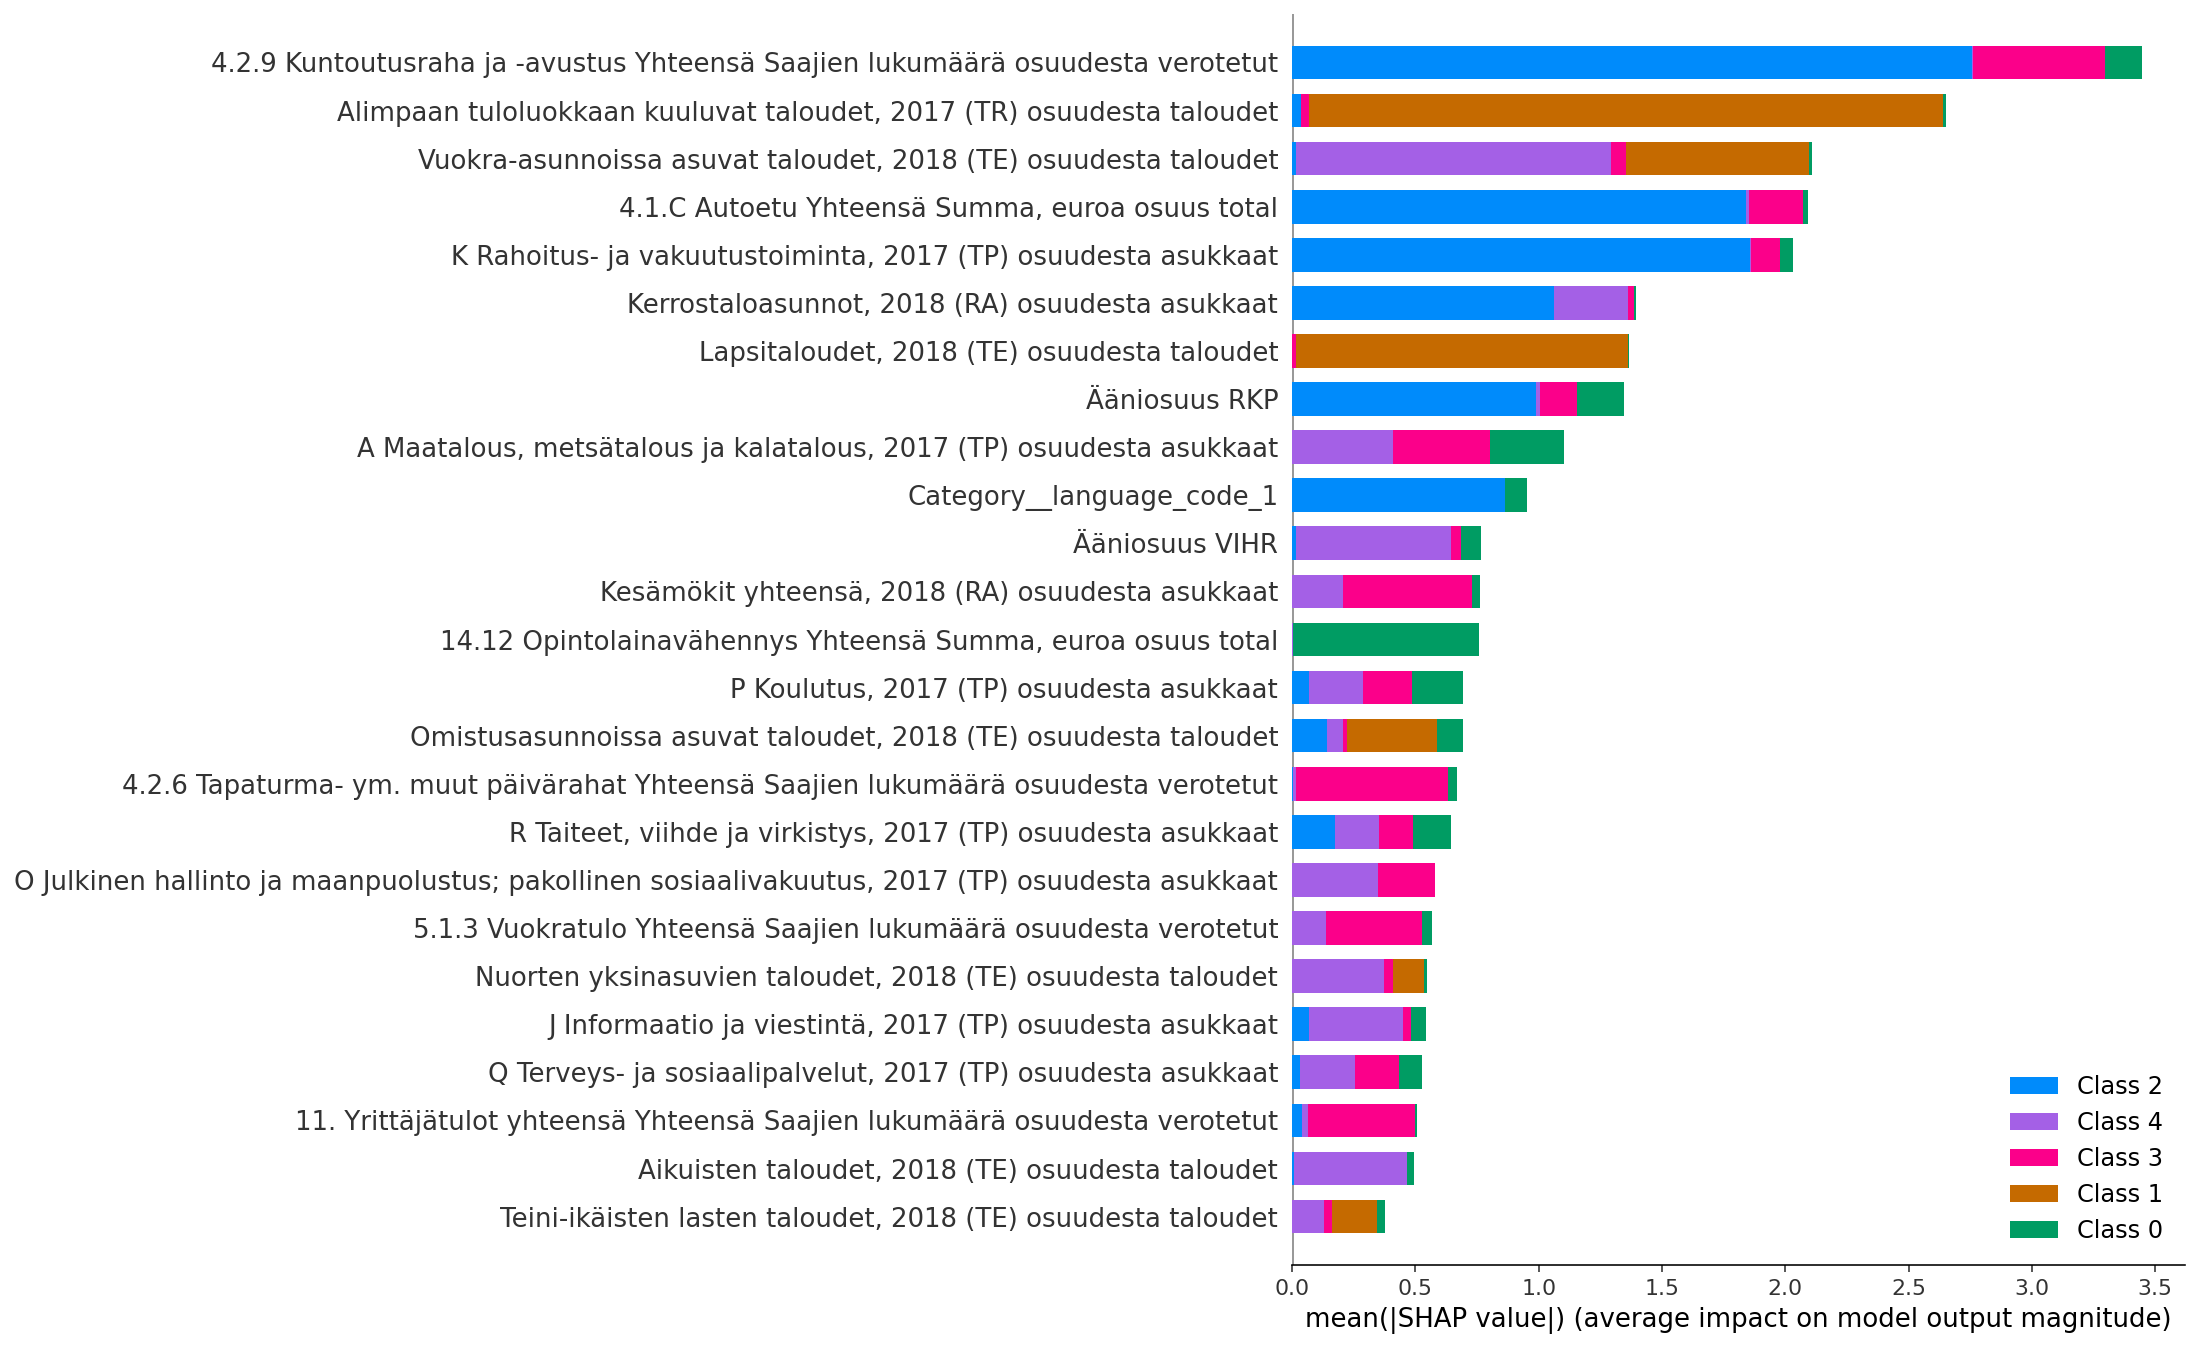

In [12]:
shap.summary_plot(shap_values, X,  max_display=25)

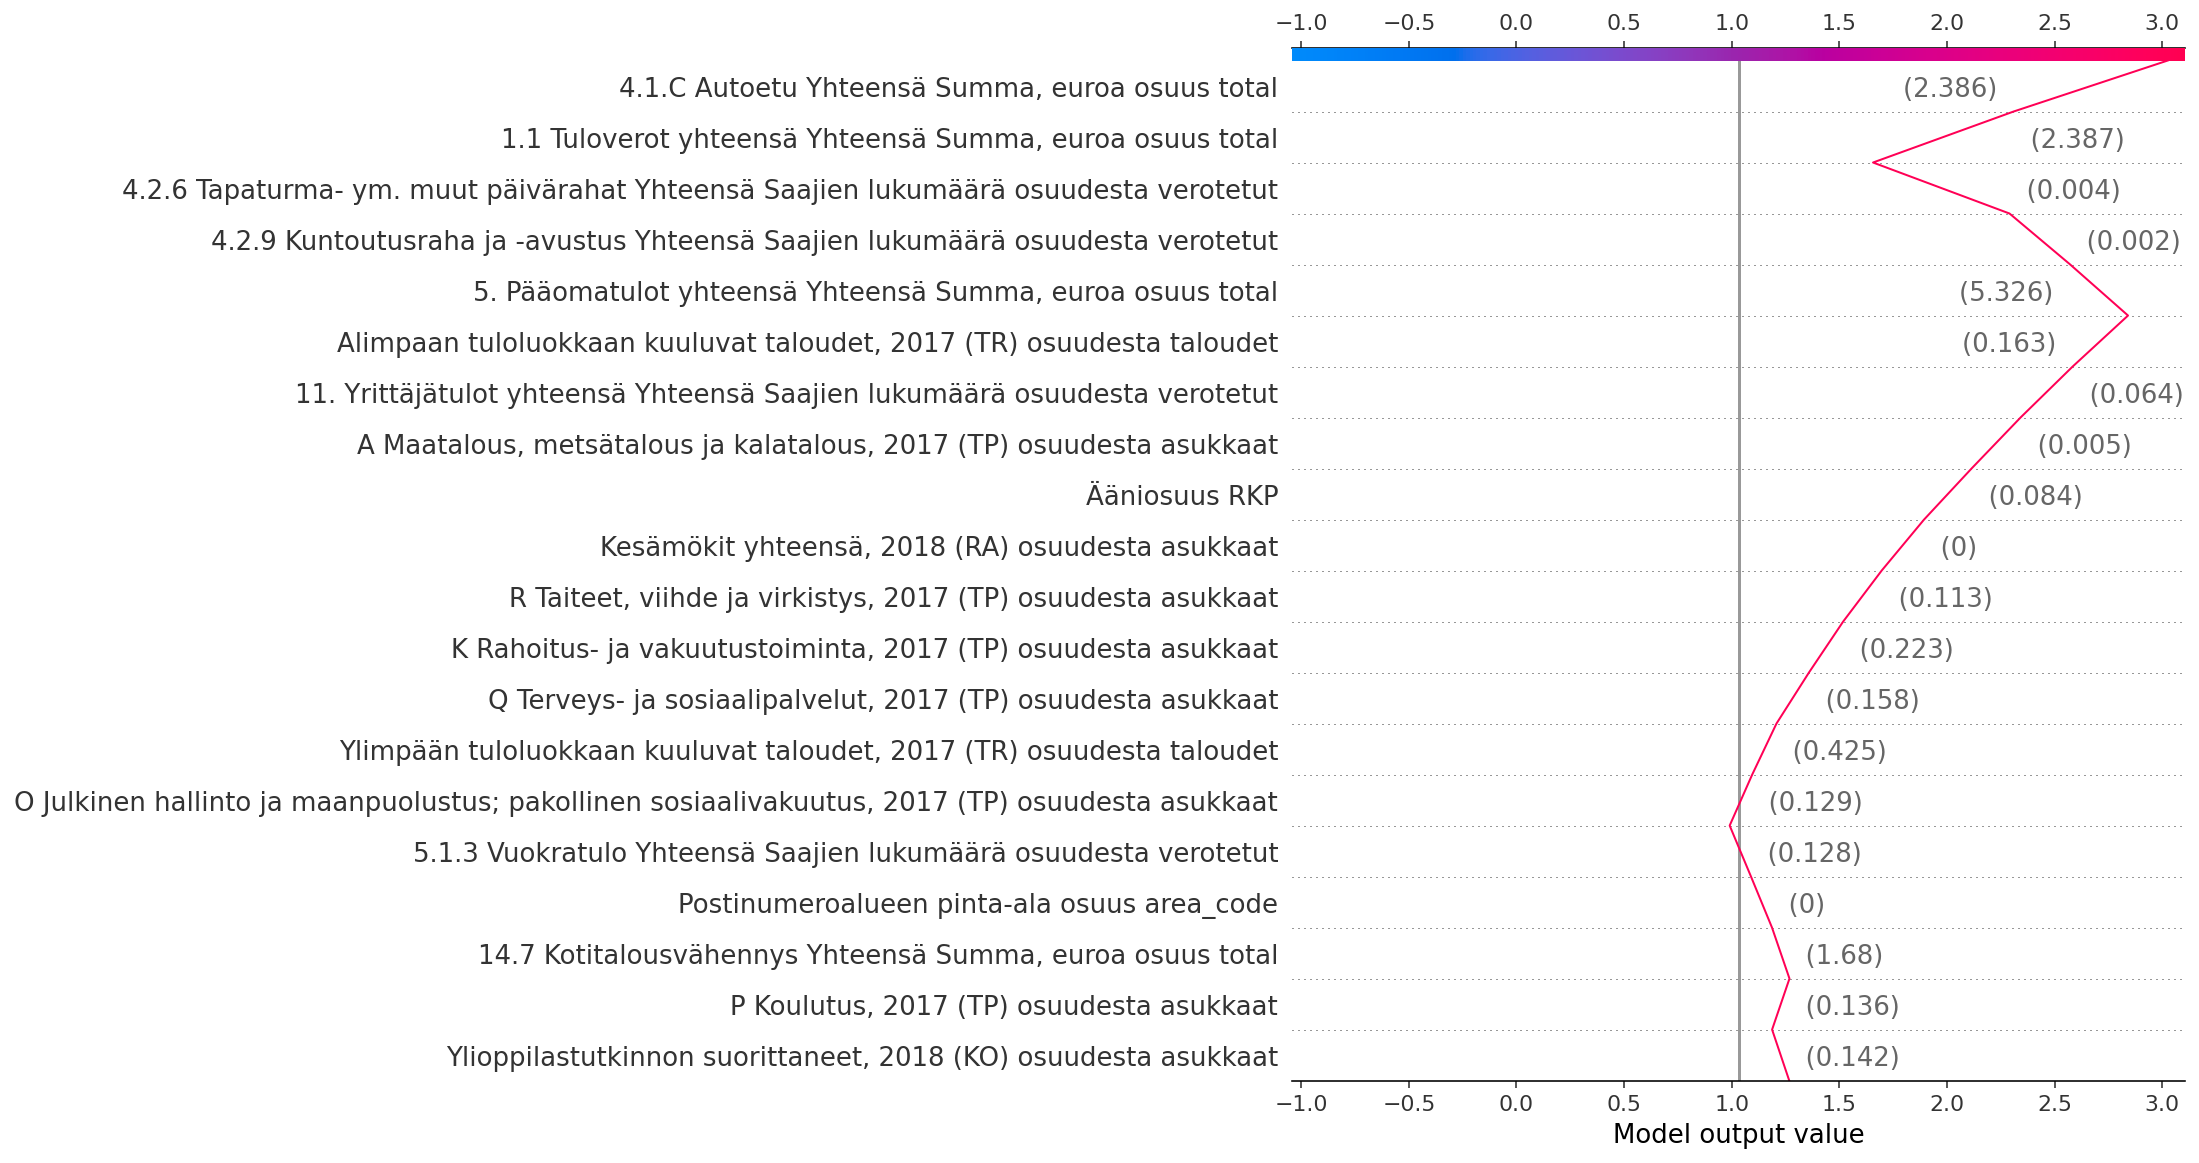

In [14]:
pnro = '02160'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
cluster = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[cluster], shap_values[cluster][idx], X)


In [ ]:
shap_values[0]


In [ ]:
id_col = 'Postinumero'
party ='KOK'
target = 'Äänet yhteensä lkm ' + party
df, X_rand, clst = shap_proba_individual(explainer[key], mymodel[key], data, target, X, id_col, pnro)

In [ ]:
print_individual_waterfall(data, target, X, shap_expected_value, shap_values, id_col, pnro)

In [ ]:
pnro = '02610'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
cluster = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[cluster], shap_values[cluster][idx], X)


In [ ]:

id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
cluster = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[cluster], shap_values[cluster][idx], X, link='logit',)


In [ ]:
new = ['Postinumero','muncipality_name','Asukkaat yhteensä, 2018 (HE)', target]
show_df, col_list = print_examples(data, X, new, target, 0, shap_values, col_num=15, n=6)
show_df

In [ ]:
shap.summary_plot(shap_interaction_values[0], X)

In [ ]:
shap.dependence_plot("rank(1)", shap_values[clst], X)

In [ ]:
clst=9
shap.summary_plot(shap_values[clst], X)

In [16]:
new = ['Postinumero','postcode_name','Asukkaat yhteensä, 2018 (HE)', target]
show_df, col_list = print_examples(data, X, new, target, 1, shap_values, col_num=15, n=20)
show_df

TypeError: print_examples() got an unexpected keyword argument 'col_num'